In [29]:
import json
import sys
import copy
from collections import defaultdict
from pathlib import Path
from operator import itemgetter
from typing import Iterable, Any
from dataclasses import dataclass, field

import pandas as pd
import numpy as np
import IPython.display as display
from tqdm import tqdm

print(sys.version)

@dataclass(order=True)
class PrioritizedItem:
    priority: int
    item: Any=field(compare=False)

    def __iter__(self):
        return iter((self.priority, self.item))

3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]


In [30]:
PATH_DATA = Path() / "../data"
INPUT_FILE = PATH_DATA / "parsed/bordils.json"


In [31]:
with open(INPUT_FILE) as f:
    data = json.load(f)

nodes_df = pd.DataFrame.from_dict(data['nodes'])
nodes_df['id'] = nodes_df['id'].astype(int) - 1
nodes_df.set_index('id', inplace=True)

nodes_df

,latitude,longitude
id,,
0,42.044220,2.910072
1,42.044310,2.911988
2,42.043863,2.911919
3,42.043188,2.910538
4,42.042121,2.912125


In [32]:

def zeroify(v):
    return v[0] - 1, v[1] - 1

streets_df = pd.DataFrame.from_dict(data['streets'])
streets_df['nodes'] = streets_df['nodes'].apply(zeroify)

streets_df

,name,nodes,bidirectional,distance
0,Carrer Ample,"(0, 1)",True,169.17
1,Carrer de la creu,"(2, 1)",True,45.24
2,Carrer de la creu,"(2, 3)",False,131.83
3,Passeig Aimeric,"(2, 4)",True,192.28
4,Carrer Almeda,"(3, 4)",True,175.33
5,Carrer Montserrat,"(3, 0)",False,175.33


In [33]:
constraints_df = pd.DataFrame.from_dict(data['constraints'])
constraints_df[['streetA', 'streetB']] = constraints_df[['streetA', 'streetB']].applymap(zeroify)


constraints_df

,streetA,streetB,maxValue
0,"(2, 3)","(2, 4)",3


In [34]:
# Create all possible connections matrix
con_matrix = np.zeros((len(nodes_df), len(nodes_df)))

for row in streets_df.itertuples():
    con_matrix[row.nodes[0], row.nodes[1]] = con_matrix[row.nodes[1], row.nodes[0]] = row.distance

con_matrix

array([[  0.  , 169.17,   0.  , 175.33,   0.  ],
       [169.17,   0.  ,  45.24,   0.  ,   0.  ],
       [  0.  ,  45.24,   0.  , 131.83, 192.28],
       [175.33,   0.  , 131.83,   0.  , 175.33],
       [  0.  ,   0.  , 192.28, 175.33,   0.  ]])

In [35]:
def solution_generator(df: pd.DataFrame, level=0, current: defaultdict[list] = None) -> Iterable[defaultdict[list]]:
    if level >= len(df):
        yield copy.deepcopy(current)
        return

    if current is None:
        current = defaultdict(list)

    value = df.loc[level]
    nodes = value['nodes']
    
    new = copy.deepcopy(current)
    new[nodes[0]].append(nodes[1])
    for sol in  solution_generator(df, level + 1, new):
        yield sol

    new = copy.deepcopy(current)
    new[nodes[1]].append(nodes[0])
    for sol in solution_generator(df, level + 1, new):
        yield sol

    new = copy.deepcopy(current)
    if value['bidirectional']:
        new[nodes[0]].append(nodes[1])
        new[nodes[1]].append(nodes[0])
        for sol in solution_generator(df, level + 1, new):
            yield sol

In [36]:
import heapq

def dijkstra(solution: dict[list], source: int):
    dist_v = [float('inf')]*len(nodes_df)
    visited = [False]*len(nodes_df)

    dist_v[source] = 0
    visited[source] = True
    q = []

    for node in solution[source]:
        heapq.heappush(q, (0, source))

    while len(q) > 0:
        dist_s, s = heapq.heappop(q)

        for node in solution[s]:
            dist = con_matrix[s, node] + dist_s
            if dist < dist_v[node]:
                dist_v[node] = dist

                if visited[node] == False:
                    visited[node] = True
                    heapq.heappush(q, (dist, node))
    
    return dist_v

def value_in_solution(value, solution: dict[list]):
    return value[0] in solution and value[1] in solution[value[0]]

def evaluate_solution(solution: dict[list]):
    total = 0

    for constraint in constraints_df.itertuples():
        val = 0

        sA = constraint.streetA
        sB = constraint.streetB
        values = [sA, sA[::-1], sB, sB[::-1]]

        for value in values:
            if value_in_solution(value, solution):
                val += 1
        if val >= constraint.maxValue:
            total += float('inf')

    for node in nodes_df.index:
        total += sum(dijkstra(solution, node))
    return total


In [37]:
solutions = []

for solution in tqdm(solution_generator(streets_df)):
    value = evaluate_solution(solution)
    heapq.heappush(solutions, PrioritizedItem(value, solution))

top = heapq.nsmallest(5, solutions)
top

324it [00:00, 717.15it/s]


[PrioritizedItem(priority=4712.47, item=defaultdict(<class 'list'>, {0: [1], 1: [0, 2], 2: [1, 3], 4: [2, 3], 3: [4, 0]})),
 PrioritizedItem(priority=4712.47, item=defaultdict(<class 'list'>, {0: [1, 3], 1: [0, 2], 2: [1, 4], 3: [2, 4], 4: [3]})),
 PrioritizedItem(priority=4901.719999999999, item=defaultdict(<class 'list'>, {0: [1], 1: [0, 2], 2: [1, 4], 3: [2, 4, 0], 4: [3]})),
 PrioritizedItem(priority=4901.72, item=defaultdict(<class 'list'>, {0: [1, 3], 1: [0, 2], 2: [1, 3], 4: [2, 3], 3: [4]})),
 PrioritizedItem(priority=4917.28, item=defaultdict(<class 'list'>, {0: [1], 1: [0, 2], 2: [1, 3], 4: [2], 3: [4, 0]}))]

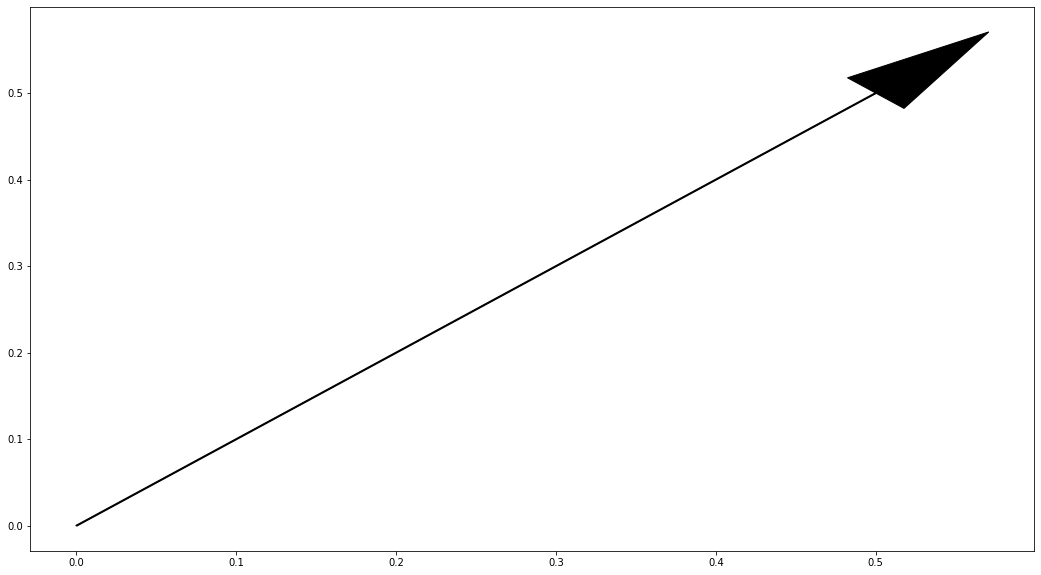

In [44]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (18, 10)

def draw_solution(solution: PrioritizedItem):
    score: int
    edges: dict[int, list[int]]
    score, edges = solution
    
    for node_src, dest_list in edges.items():
        src_coord = nodes_df.loc[node_src, ['latitude', 'longitude']]
        x, y = src_coord

        for node_dest in dest_list:
            dest_coord = nodes_df.loc[node_dest, ['latitude', 'longitude']] - src_coord
            dx, dy = dest_coord
            # plt.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, fc='k', ec='k')

    plt.show()


draw_solution(top[0])